In [1]:
import pandas as pd
import numpy as np
fp = "data/user_item_utility_matrix.csv"
df = pd.read_csv(fp)
df_u = df["Customer ID"]
col_y = ["MonetaryValue", "freq", "recency"] 
cols = df.columns.tolist()
col_exclude = ["MonetaryValue", "freq", "recency", "Customer ID"]
col_x = [ c for c in cols if c not in col_exclude]
df_y = df[col_y]
df_x = df[col_x]

In [2]:
from sklearn import preprocessing
x = df_y.values #returns a numpy array
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)
df_y = pd.DataFrame(x_scaled)
df_y.columns = col_y

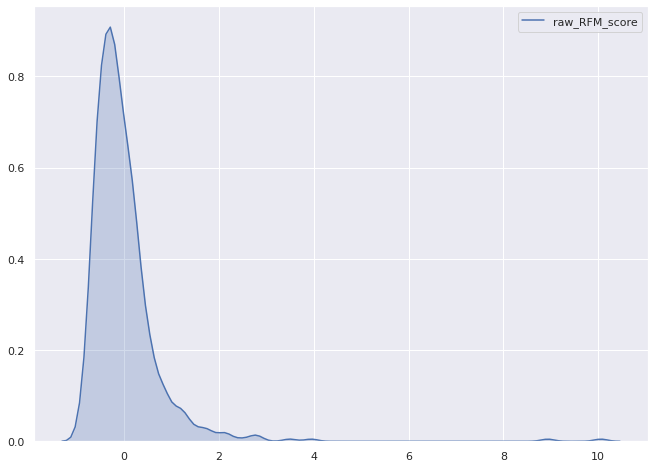

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
weights = {'wt_mv':0.7, 'wt_freq': 0.15, 'wt_rec': 0.15}
def assign_raw_RFM_score(row):
    score = weights['wt_mv']*row["MonetaryValue"] + \
    weights["wt_freq"] * row["freq"] + weights["wt_rec"]*  row["recency"]
    return score
df_y['raw_RFM_score'] = df_y.apply(func = assign_raw_RFM_score, axis = 1)

plt.rcParams['figure.figsize'] = [11, 8]
sns.set(color_codes=True)
sns.kdeplot(df_y["raw_RFM_score"], shade = True)

In [4]:
df_y = df[col_y]
df_y.describe()

,MonetaryValue,freq,recency
count,618.000000,618.000000,618.000000
mean,2377.134045,9.241100,40.909191
std,1934.444008,9.849851,49.214604
min,70.020000,5.000000,1.000000
25%,1335.452500,6.000000,13.022743
50%,1993.995000,7.000000,24.263194
75%,2897.127500,10.000000,53.913368
max,26832.500000,184.000000,667.077778


In [5]:
from sklearn.preprocessing import power_transform
trans_y = power_transform(df_y, method='box-cox', standardize=False)

In [6]:
df_trans_y = pd.DataFrame(trans_y)
df_trans_y.columns = ["bc_MV", "bc_freq", "bc_recency"]
weights = {'wt_mv':0.7, 'wt_freq': 0.15, 'wt_rec': 0.15}
def assign_RFM_score(row):
    score = weights['wt_mv']*row["bc_MV"] + \
    weights["wt_freq"] * row["bc_freq"] + weights["wt_rec"]*  row["bc_recency"]
    return score
df_trans_y['RFM_score'] = df_trans_y.apply(func = assign_RFM_score, axis = 1)

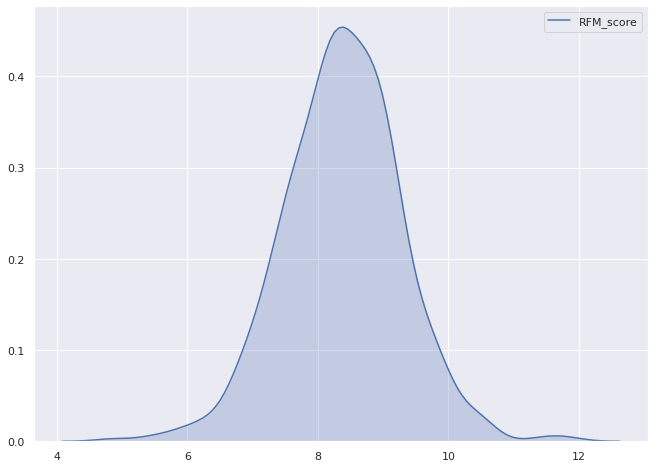

In [7]:
plt.rcParams['figure.figsize'] = [11, 8]
sns.set(color_codes=True)
sns.kdeplot(df_trans_y["RFM_score"], shade = True)

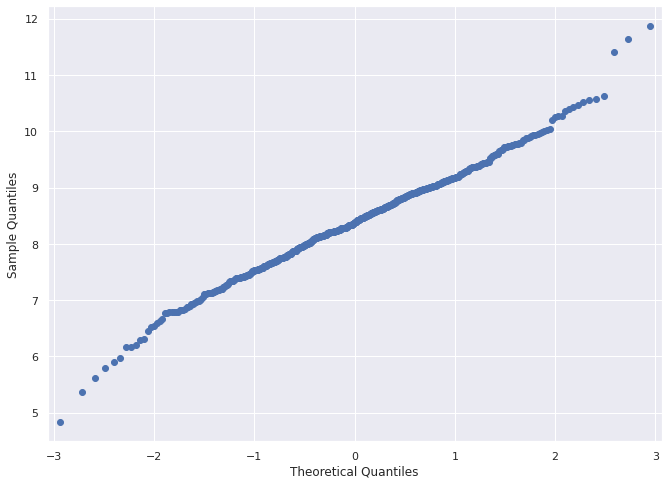

In [8]:
import statsmodels.api as sm
fig = sm.qqplot(df_trans_y["RFM_score"])
plt.show()

In [9]:
Y = df_trans_y["RFM_score"].values
X = df_x.values


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
TRNG_SIZE = X_train.shape[0]
TEST_SIZE = X_test.shape[0]

/home/admin2/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


           Metric  Value
0    Training MSE  0.158
1        Test MSE  0.404
2  Training $R^2$  0.786
3      Test $R^2$  0.560


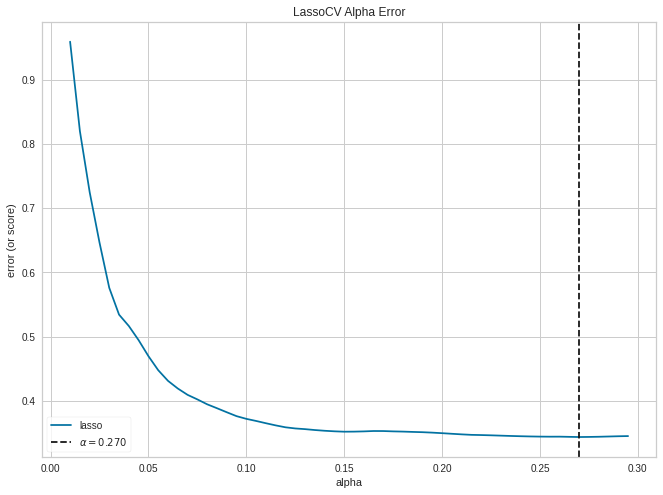

In [11]:
from yellowbrick.regressor import AlphaSelection
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
Xexp = X_train
Yexp = Y_train
Xtexp = X_test
Ytexp = Y_test
alphas = np.arange(0.01, 0.3, 0.005)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

#reg_exp = ElasticNetCV(alphas = alphas, cv = kfold, max_iter=10000)
reg_exp = LassoCV(alphas = alphas, cv = kfold, max_iter=10000)

reg_exp.fit(Xexp, Yexp.ravel())
exp_score = reg_exp.score(Xexp, Yexp)
y_trng_pred = reg_exp.predict(Xexp)
y_test_pred = reg_exp.predict(Xtexp)
trng_fit_score = "%0.3f"%reg_exp.score(Xexp, Yexp)
test_fit_score = "%0.3f"%reg_exp.score(Xtexp, Ytexp)
e_trng_mse = "%0.3f"%mean_squared_error(Yexp, y_trng_pred)
e_test_mse = "%0.3f"%mean_squared_error(Ytexp,y_test_pred)

fes = {"Training MSE": e_trng_mse,
       "Test MSE": e_test_mse,
       "Training $R^2$": trng_fit_score,
       "Test $R^2$": test_fit_score}
df_fes = pd.DataFrame(fes.items())
df_fes.columns = ["Metric", "Value"]
print(df_fes)
plt.rcParams['figure.figsize'] = [11, 8]
visualizer = AlphaSelection(reg_exp)
visualizer.fit(Xexp, Yexp)
visualizer.show()

In [23]:
ord_indices = reg_exp.coef_.ravel().argsort()[::-1]
num_features = np.arange(2,200, 2)
from sklearn.linear_model import LinearRegression
trng_err = []
test_err = []
for nf in num_features:
    Xtrngexp = X_train[:, ord_indices[:nf]]
    Xtestexp = X_test[:, ord_indices[:nf]]
    Ytrngexp = Y_train
    Ytestexp = Y_test
    rfsm = LinearRegression()
    rfsm.fit(Xtrngexp, Ytrngexp.ravel())
    y_trng_pred = rfsm.predict(Xtrngexp)
    y_test_pred = rfsm.predict(Xtestexp)
    trngmse = round(mean_squared_error(Y_train, y_trng_pred), 3)
    testmse = round(mean_squared_error(Y_test, y_test_pred), 3)
    trng_err.append(trngmse)
    test_err.append(testmse)
    gap_ratio = float(trngmse)/float(testmse)
    #print('for {} features, training error is {}, test error is {}'.format(nf, trngmse, testmse))
    #print('for {} features, gap_ratio is {:.3f}, training error is {}, test err is {}'.format(nf, gap_ratio, trngmse, testmse))
    

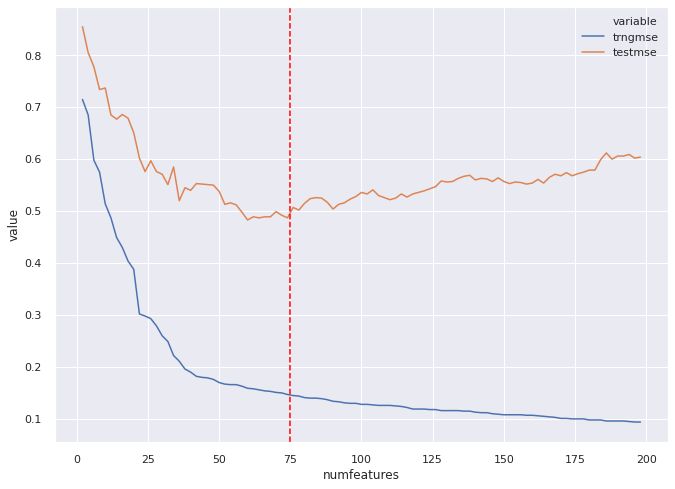

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
NUM_FEATURES_OPT = 75
aed = {"numfeatures": num_features, "trngmse": trng_err, "testmse": test_err}
df_nf_sel = pd.DataFrame(aed)
cols_to_plot = ["numfeatures", "trngmse", "testmse"]
df_plot = df_nf_sel[cols_to_plot]
df_ep = df_plot.melt(id_vars = ['numfeatures'])
df_ep["value"] = df_ep["value"].astype(np.float)

plt.rcParams['figure.figsize'] = [11, 8]
sns.set(color_codes=True)
sns.lineplot(x='numfeatures', y='value', hue='variable', data = df_ep)
plt.axvline(x = NUM_FEATURES_OPT, color ='red', linestyle= '--') 

In [15]:
feats = col_x
if "Customer ID" in feats:
    feats.remove("Customer ID")
feats = np.array(feats)
bm_ord_ind = reg_exp.coef_.ravel().argsort()[::-1]
feats = feats.ravel()[bm_ord_ind][:NUM_FEATURES_OPT]
bmcoefs = reg_exp.coef_.ravel()[bm_ord_ind][:NUM_FEATURES_OPT]

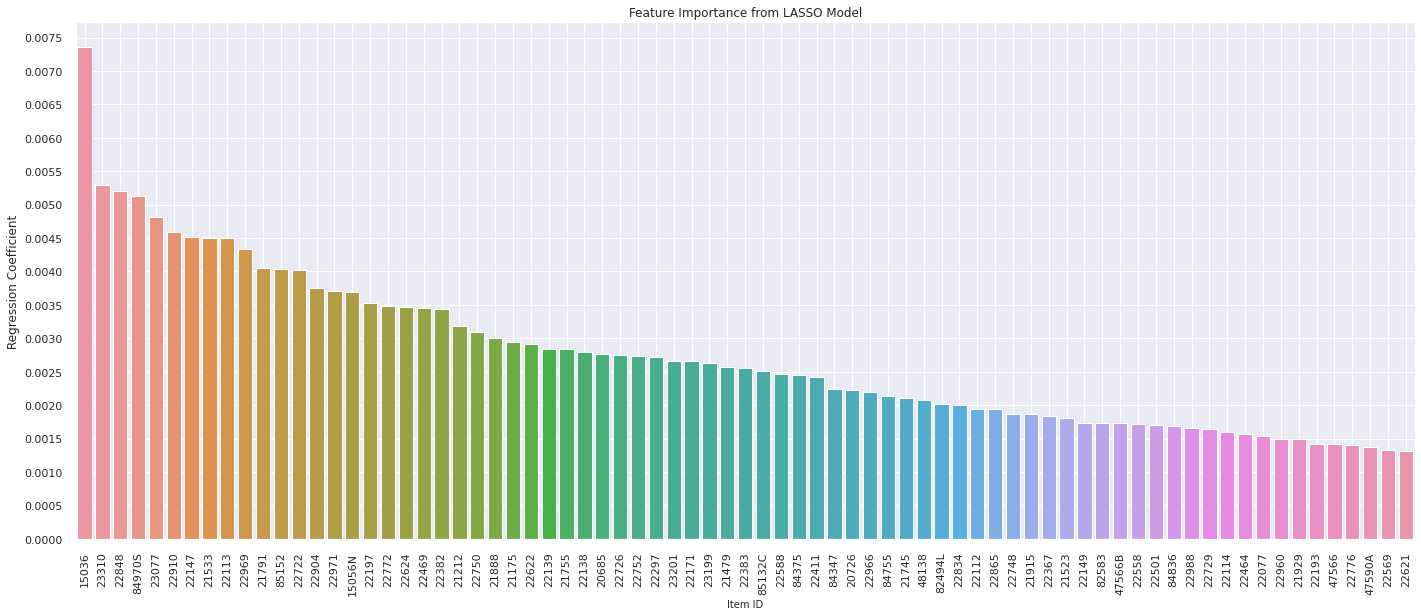

In [16]:
import matplotlib.ticker as ticker
plt.rcParams['figure.figsize'] = [24, 9.5]
plt.rcParams['xtick.labelsize'] = 'xx-small'
sns.set(color_codes=True)
g = sns.barplot(x = feats, y = bmcoefs, ci = None)
plt.title("Feature Importance from LASSO Model")
plt.grid(True)
plt.xlabel('Item ID', fontsize=10)
plt.ylabel('Regression Coefficient')
plt.locator_params(axis='y', nbins=20)
l = g.set_xticklabels(feats, rotation=90)